### Implementation of Bayesian structure alignment

The goal of this notebook is to implement an algorithm to align two protein structures. This work is based heavily on the Pyro implementation of this problem published by Moreta et al (https://www.biorxiv.org/content/early/2019/06/04/575431.full.pdf). 

In [122]:
%pylab inline

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS

Populating the interactive namespace from numpy and matplotlib


/Users/jgreisman/anaconda2/envs/md/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
atoms = 50
iters = 1000
X1 = np.random.random((atoms, 3))
X2 = X1 + np.random.normal(0, 0.01, (atoms, 3))

In [3]:
X1,X2 = torch.tensor(X1, dtype=torch.float32), torch.tensor(X2, dtype=torch.float32)

In [123]:
def u_to_quat_to_R(u):
    [t1,t2,r1,r2] = [
        2*np.pi*u[1],
        2*np.pi*u[2],
        torch.sqrt(1-u[0]),
        torch.sqrt(u[0]),
    ]

    [w,x,y,z] = [
        r2*torch.cos(t2),
        r1*torch.sin(t1),
        r1*torch.cos(t1),
        r2*torch.sin(t2),
    ]

    R = torch.tensor([
        [w*w + x*x - y*y - z*z,     2*(x*y-w*z),     2*(x*z+w*y)],
        [          2*(x*y+w*z), w*w-x*x+y*y-z*z,   2*(y*z - w*x)],
        [          2*(x*z-w*y),     2*(y*z+w*x), w*w-x*x-y*y+z*z],
    ], dtype=torch.float32)
    return R

In [30]:
def model():
    N = 50
    # Prior over mean M, with N=number of atoms
    M = pyro.sample("M", dist.StudentT(1,0,3).expand_by([N,3]).to_event(2))
    # Prior over variances U
    U = pyro.sample("U", dist.HalfNormal(1).expand_by([N]).to_event(1))
    U = U.reshape(N,1).repeat(1,3).view(-1)
    # Prior over translation T
    T = pyro.sample("T", dist.Normal(0,1).expand_by([3]).to_event(1))
    # Prior over rotation R
    u = pyro.sample("u",dist.Uniform(0,1).expand_by([3]).to_event(1))
    # Transformation: turn u via a unit quaternion into a rotation R
    R = u_to_quat_to_R(u)
    # Transformation: rotate and translate M for X2
    M_RT = M @ R + T
    # Likelihood
    with pyro.plate("plate_students", N*3,dim= -1):
        pyro.sample("X1", dist.StudentT(1, M.view(-1), U), obs=X1.view(-1))
        pyro.sample("X2", dist.StudentT(1, M_RT.view(-1), U), obs=X2.view(-1))

In [5]:
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import Trace_ELBO
from pyro.optim import Adam

guide = AutoDelta(model)
optim = Adam({'lr': 0.03})
svi = pyro.infer.SVI(model, guide, optim, loss=Trace_ELBO())


losses=[]
for i in range(10000):
    losses.append(svi.step())


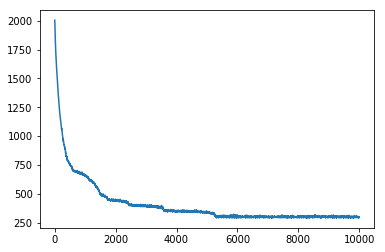

In [6]:
plot(losses)

In [9]:
answer = guide()

### Apply to a real protein

I will grab two frames from an MD trajectory and use this method to align them.

In [119]:
import mdtraj

# Input structures
x1 = mdtraj.load("ref.pdb")
x2 = mdtraj.load("target.pdb")

# Placeholder trajectories for results
mover = x1[0]
m = x1[0]

In [120]:
X1 = torch.tensor(x1.xyz[0], dtype=torch.float32)
X2 = torch.tensor(x2.xyz[0], dtype=torch.float32)
print(X1)

tensor([[1.6271, 0.6045, 2.5373],
        [1.5632, 0.7143, 2.4642],
        [1.6662, 0.7874, 2.3812],
        ...,
        [4.8180, 2.6577, 2.7567],
        [4.9805, 2.5987, 2.9811],
        [4.9957, 2.7432, 2.8764]])


In [121]:
N=1231
def model2():
    N=1231
    # Prior over mean M, with N=number of atoms
    M = pyro.sample("M", dist.StudentT(1,0,3).expand_by([N,3]).to_event(2))
    # Prior over variances U
    U = pyro.sample("U", dist.HalfNormal(1).expand_by([N]).to_event(1))
    U = U.reshape(N,1).repeat(1,3).view(-1)
    # Prior over translation T
    T = pyro.sample("T", dist.Normal(0,1).expand_by([3]).to_event(1))
    # Prior over rotation R
    u = pyro.sample("u",dist.Uniform(0,1).expand_by([3]).to_event(1))
    # Transformation: turn u via a unit quaternion into a rotation R
    R = u_to_quat_to_R(u)
    # Transformation: rotate and translate M for X2
    M_RT = M @ R + T
    
    df = pyro.sample("df", dist.LogNormal(10, 2))
    
    # Likelihood
    with pyro.plate("plate_students", N*3,dim= -1):
        pyro.sample("X1", dist.StudentT(df, M.view(-1), U), obs=X1.view(-1))
        pyro.sample("X2", dist.StudentT(df, M_RT.view(-1), U), obs=X2.view(-1))

In [109]:
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import Trace_ELBO
from pyro.optim import Adam, AdagradRMSProp

guide2 = AutoDelta(model2)
# optim2 = Adam({'lr': 0.01})
# optim2 = AdagradRMSProp({'lr': 1.0, 'momentum':0.1, 'eps':1e-16})
optim2 = AdagradRMSProp({})
svi2 = pyro.infer.SVI(model2, guide2, optim2, loss=Trace_ELBO())


losses=[]
for i in range(2000):
    losses.append(svi2.step())

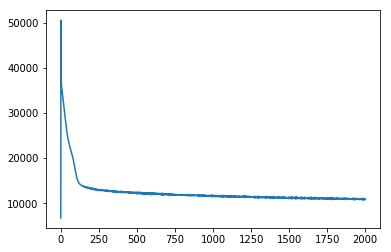

In [110]:
plot(losses)

In [111]:
answer = guide2()
answer["df"]

tensor(0.4753, grad_fn=<ExpandBackward>)

In [89]:
moved = x1.xyz[0] @ u_to_quat_to_R(answer["u"]).detach().numpy() + answer["T"].detach().numpy()

In [90]:
moved.xyz = moved
moved.save("moved.pdb")

In [91]:
m.xyz = answer["M"].detach().numpy()
m.save("M.pdb")